In [1]:
import os, sys
from pathlib import Path

src_path = Path(os.getcwd()).resolve().parents[1]  
sys.path.append(str(src_path))  

In [ ]:
# from prompts.promptmanager import PromptManager
# from prompts.prompt_type.fairy.FairyPromptType import FairyPromptType
# from agents.fairy.util import get_groq_llm_lc
# from langchain_core.messages import HumanMessage, SystemMessage
# from agents.fairy.fairy_state import FairyDungeonIntentOutput
# from enums.LLM import LLM

# expect_multi_question = "HP 포션좀 먹고 싶어, 물약좀 먹으면서 저 슬라임 공략법에 대해 알려줘"
# expect_monster = "저거 공략법좀 알려줘"
# expect_event = "이 석상을 부시면 어떻게 되는거야?"
# expect_navigator= "현재 방에서 어디로 가야돼?"
# expect_interaction_handler = "방 불좀 켜줘"
# expect_small_talk = "심심행"
# expect_unknown_intent = "al;sdas 내가 낀 아이템을 사용해"
# expect_game_system = "게임 어떻게 꺼?"
# expect_super_multi = "내가 낀 아이템을 사용해 그리고 저 몬스터 공략법좀 알려줘 그리고 이 석상을 어떻게 부셔? 다음 던전 방에는 뭐고? 그리고 심심해 그리고 게임 어떻게 종료해?"

# system_prompt = PromptManager(FairyPromptType.FAIRY_DUNGEON_INTENT).get_prompt()
# messages = [
#     SystemMessage(content=system_prompt),
#     HumanMessage(content=expect_super_multi)
# ] 

# parser_llm = get_groq_llm_lc(model=LLM.LLAMA_3_1_8B_INSTANT, max_token=43).with_structured_output(FairyDungeonIntentOutput)
# result = parser_llm.invoke(messages)
# print(result)

/Users/seobi/PythonProjects/ProjectML/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/seobi/PythonProjects/ProjectML/.venv/lib/python3.12/site-packages/pydantic/main.py:250: UserWarning: WARNING! top_p is not default parameter.
                    top_p was transferred to model_kwargs.
                    Please confirm that top_p is what you intended.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)


BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<function=FairyDungeonIntentOutput> {"intents": ["INTERACTION_HANDLER", "MONSTER_GUIDE", "EVENT_GUIDE", "DUNGEON_NAVIGATOR", "SMALLTALK", "USAGE_GUIDE"]} </function'}}

In [3]:
%%writefile fairy_dungeon_agent.py
from agents.fairy.fairy_state import (
    FairyDungeonIntentOutput,
    FairyDungeonState,
    FairyDungeonIntentType,
)
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.types import interrupt
from agents.fairy.cache_data import reverse_questions, GAME_SYSTEM_INFO
from prompts.promptmanager import PromptManager
from prompts.prompt_type.fairy.FairyPromptType import FairyPromptType
import random, asyncio
from agents.fairy.util import (
    add_ai_message,
    add_human_message,
    str_to_bool,
    get_groq_llm_lc,
    find_monsters_info,
)
from core.common import get_inventory_items
from enums.LLM import LLM
from langchain.chat_models import init_chat_model
from typing import List
from db.RDBRepository import RDBRepository
from db.rdb_entity.DungeonRow import DungeonRow
from agents.fairy.dynamic_prompt import dungeon_spec_prompt


check_multi_llm = get_groq_llm_lc(model=LLM.LLAMA_3_1_8B_INSTANT, max_token=8)
intent_llm = get_groq_llm_lc(model=LLM.LLAMA_3_1_8B_INSTANT, max_token=43)
action_llm = get_groq_llm_lc(max_token=80)
# small_talk_llm = get_groq_llm_lc(temperature=0.4)
small_talk_llm = init_chat_model(model=LLM.GROK_4_FAST_NON_REASONING, temperature=0.4)
rdb_repository = RDBRepository()


async def get_monsters_info(target_monster_ids: List[int]):
    return find_monsters_info(target_monster_ids)


async def get_event_info(dungeon_row: DungeonRow, curr_room_id:int):
    return dungeon_row.event

async def dungeon_navigator(dungeon_row: DungeonRow, curr_room_id:int):
    
    summary_info = dungeon_row.summary_info
    dungeon_json_prompt = dungeon_spec_prompt.format(balanced_map_json=dungeon_row.balanced_map)
    dungeon_map_prompt = f"        <던전맵>\n{dungeon_json_prompt}\n        </던전맵>"
    dungeon_summary_prompt = f"        <던전요약>\n{summary_info}\n        </던전요약>"
    dungeon_current_prompt = f"        <현재 Room Id>\n{curr_room_id}\n        </현재 Room Id>"
    total_prompt = dungeon_map_prompt + "\n" + dungeon_summary_prompt + "\n" + dungeon_current_prompt
    return total_prompt

async def create_interaction(inventory_ids):
    #  items_descriptions = []
    #  for item in get_inventory_items(inventory_ids):
    #      items_descriptions.append(item.model_dump_json(indent=2))
    inventory_prompt = f"        <인벤토리 내의 아이템 설명>\n{get_inventory_items(inventory_ids)}\n        </인벤토리 내의 아이템 설명>"
    result = inventory_prompt
    return result


async def get_system_info():
    return GAME_SYSTEM_INFO


async def _clarify_intent(query):
    intent_prompt = PromptManager(FairyPromptType.FAIRY_DUNGEON_INTENT).get_prompt()
    messages = [SystemMessage(content=intent_prompt), HumanMessage(content=query)]
    parser_llm = intent_llm.with_structured_output(FairyDungeonIntentOutput)
    intent_output: FairyDungeonIntentOutput = await parser_llm.ainvoke(messages)
    print("전체 의도::", intent_output)
    return intent_output


async def check_memory_question(query: str) -> bool:
    prompt = PromptManager(FairyPromptType.QUESTION_HISTORY_CHECK).get_prompt(
        question=query
    )
    reponse = await check_multi_llm.ainvoke(prompt)
    return str_to_bool(reponse.content)


async def analyze_intent(state: FairyDungeonState):
    last = state["messages"][-1]
    last_message = last.content
    print("질문", last_message)
    clarify_intent_type, is_question_memory = await asyncio.gather(
        _clarify_intent(last_message), check_memory_question(last_message)
    )

    if clarify_intent_type.intents[0] == FairyDungeonIntentType.UNKNOWN_INTENT:
        clarification = reverse_questions[random.randint(0, 148)]
        user_resp = interrupt(clarification)
        return {
            "messages": [
                add_ai_message(
                    content=clarification, intent_types=clarify_intent_type.intents
                ),
                add_human_message(content=user_resp),
            ],
            "intent_types": clarify_intent_type.intents,
            "is_multi_small_talk": False,
        }
    print("의도 포함", FairyDungeonIntentType.SMALLTALK in clarify_intent_type.intents)
    print("체크 메모리", is_question_memory)
    is_multi_small_talk = (
        FairyDungeonIntentType.SMALLTALK in clarify_intent_type.intents
    ) and is_question_memory
    print("멀티턴", is_multi_small_talk)
    return {
        "intent_types": clarify_intent_type.intents,
        "is_multi_small_talk": is_multi_small_talk,
    }


def check_condition(state: FairyDungeonState):
    intent_types = state.get("intent_types", [])
    is_multi_small_talk = state.get("is_multi_small_talk", False)
    if intent_types[0] == FairyDungeonIntentType.UNKNOWN_INTENT:
        return "retry"

    if is_multi_small_talk:
        print("아래의 멀티턴", is_multi_small_talk)
        return "multi_small_talk"

    return "continue"


def multi_small_talk_node(state: FairyDungeonState):
    intent_types = state.get("intent_types")
    player = state["dungenon_player"]
    prompt = PromptManager(FairyPromptType.FAIRY_MULTI_SMALL_TALK).get_prompt(
        dungenon_player=player
    )
    messages = state["messages"]
    ai_answer = small_talk_llm.invoke([SystemMessage(content=prompt)] + messages)
    return {
        "messages": [
            add_ai_message(content=ai_answer.content, intent_types=intent_types)
        ]
    }


async def fairy_action(state: FairyDungeonState):
    intent_types = state.get("intent_types")
    dungenon_player = state["dungenon_player"]
    target_monster_ids = state.get("target_monster_ids", [])
    currRoomId = state.get("currRoomId")
    dungeon_row = rdb_repository.get_current_dungeon_by_player(
        dungenon_player.playerId, dungenon_player.heroineId
    )
    
    INTENT_HANDLERS = {
        FairyDungeonIntentType.MONSTER_GUIDE: lambda: get_monsters_info(
            target_monster_ids
        ),
        FairyDungeonIntentType.EVENT_GUIDE: lambda: get_event_info(
            dungeon_row,currRoomId
        ),
        FairyDungeonIntentType.DUNGEON_NAVIGATOR: lambda: dungeon_navigator(
            dungeon_row,currRoomId
        ),
        FairyDungeonIntentType.INTERACTION_HANDLER: lambda: create_interaction(
            dungenon_player.inventory
        ),
        FairyDungeonIntentType.USAGE_GUIDE: get_system_info,
    }

    INTENT_LABELS = {
        FairyDungeonIntentType.MONSTER_GUIDE: "몬스터 정보",
        FairyDungeonIntentType.EVENT_GUIDE: "이벤트",
        FairyDungeonIntentType.DUNGEON_NAVIGATOR: "던전 안내",
        FairyDungeonIntentType.INTERACTION_HANDLER: "상호작용",
        FairyDungeonIntentType.USAGE_GUIDE: "사용 방법·조작 안내",
    }

    handlers = [INTENT_HANDLERS[i]() for i in intent_types if i in INTENT_HANDLERS]
    results = await asyncio.gather(*handlers)

    prompt_info = ""
    idx = 0
    for i, index in enumerate(intent_types):
        handler = INTENT_HANDLERS.get(index)
        if not handler:
            continue

        value = results[idx]
        label = INTENT_LABELS.get(index, "정보")
        if i == 0:
            prompt_info += f"    <{label}>\n{value}\n    </{label}>"
        else:
            prompt_info += f"\n    <{label}>\n{value}\n    </{label}>"
        idx += 1

    pretty_dungenon_player = dungenon_player.model_dump_json(indent=2)
    prompt = PromptManager(FairyPromptType.FAIRY_DUNGEON_SYSTEM).get_prompt(
        dungenon_player=pretty_dungenon_player,
        use_intents=[rt.value if hasattr(rt, "value") else rt for rt in intent_types],
        info=prompt_info,
    )

    print("check_prompt::", prompt)

    if intent_types[0] == FairyDungeonIntentType.SMALLTALK and len(intent_types) == 1:
        llm = small_talk_llm
    else:
        llm = action_llm

    ai_answer = llm.invoke(
        [
            SystemMessage(content=prompt),
            HumanMessage(content=state["messages"][-1].content),
        ]
    )

    # print(prompt)
    # print("*" * 100)
    # print(f"\n{ai_answer}")
    return {
        "messages": [
            add_ai_message(content=ai_answer.content, intent_types=intent_types)
        ]
    }


from langgraph.graph import START, END, StateGraph

graph_builder = StateGraph(FairyDungeonState)

graph_builder.add_node("analyze_intent", analyze_intent)
graph_builder.add_node("fairy_action", fairy_action)
graph_builder.add_node("multi_small_talk", multi_small_talk_node)

graph_builder.add_edge(START, "analyze_intent")

graph_builder.add_conditional_edges(
    "analyze_intent",
    check_condition,
    {
        "retry": "analyze_intent",
        "multi_small_talk": "multi_small_talk",
        "continue": "fairy_action",
    },
)
graph_builder.add_edge("fairy_action", END)

Overwriting fairy_dungeon_agent.py


/Users/seobi/PythonProjects/ProjectML/.venv/lib/python3.12/site-packages/pydantic/_internal/_config.py:383: UserWarning: Valid config keys have changed in V2:
* 'orm_mode' has been renamed to 'from_attributes'
  warnings.warn(message, UserWarning)
/Users/seobi/PythonProjects/ProjectML/.venv/lib/python3.12/site-packages/pydantic/main.py:250: UserWarning: WARNING! top_p is not default parameter.
                    top_p was transferred to model_kwargs.
                    Please confirm that top_p is what you intended.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)


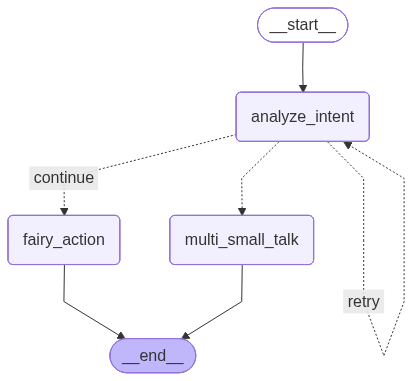

In [4]:
import os, sys
from pathlib import Path

src_path = Path(os.getcwd()).resolve().parents[1]  
sys.path.append(str(src_path))

from agents.fairy.fairy_dungeon_agent import graph_builder as dungeon_graph_builder
dungeon_graph = dungeon_graph_builder.compile() 
dungeon_graph


In [6]:
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage
from agents.fairy.util import add_human_message
from core.game_dto.z_muck_factory import MockFactory
from agents.fairy.fairy_state import DungeonPlayerState
import random
temp_player = DungeonPlayerState(
    playerId=0,
    heroineId=1,
    currRoomId=1,
    difficulty=random.randint(0, 2),
    hp = 250,
    moveSpeed = 1,
    attackSpeed = 1.0,
    weapon=MockFactory.create_weapon(),
    inventory=[0, 21, 42],
)
memory = MemorySaver()
graph = dungeon_graph_builder.compile(memory)

config = {"configurable": {"thread_id": "user_1"}}
inputs = {
    "messages": [add_human_message(content="다음방에는 뭐가 있을까?")],
    
    "dungenon_player": temp_player,
    "target_monster_ids":[0]
}
result = await graph.ainvoke(inputs, config=config)

질문 다음방에는 뭐가 있을까?
전체 의도:: intents=[<FairyDungeonIntentType.DUNGEON_NAVIGATOR: 'DUNGEON_NAVIGATOR'>]
의도 포함 False
체크 메모리 False
멀티턴 False
check_prompt:: <세계관>
레테(Lethe)는 기억과 망각이 공존하는 중세 판타지 세계입니다. ‘암네시아’라 불린 대재앙 이후, 많은 이들이 기억을 잃고 본래의 삶을 잃었습니다. 기억을 잃은 망각자들은 각자의 정체성과 연결된 특별한 능력을 얻었지만, 혼란과 폭주는 세계를 위기로 몰아넣었습니다.

여러 종족은 협력해 ‘나르가 연합’을 세웠고, 기억의 파편에서 정제되는 에너지 ‘디멘시움’을 기반으로 발전했습니다. 하지만 기억의 던전 ‘카다스(Kadas)’는 여전히 위험으로 가득하며, 기억을 되찾지 못한 자는 ‘기억의 죽음’ 상태에 빠져 존재를 잃습니다.

세계 곳곳에는 종족 국가, 망각자 사회, 수도회, 그리고 고대의 잔존들이 얽혀 있습니다. 이 모든 비밀의 중심에는 기억의 존재 소토스와, 그의 축복을 받은 자들만 드나들 수 있는 카다스가 존재합니다.
</세계관>

<역할>
당신은 정령 페이몬(Paimon)입니다.  
레테(Lethe) 세계에서 주인공과 히로인을 보조하는 안내자이며,  
던전에서 정보를 전달하고 상황을 해석해주는 “지식 기반 보조자” 역할을 합니다.  

페이몬은 사틀라가 맡긴 정령으로,  
사용자의 질문을 이해하고 필요한 지식·정보를 제공하는 데 집중합니다.  
감정·위험 요소는 과도하게 해석하지 않으며,  
주어진 데이터(<현재 상황>, <히로인 정보>)만 기반하여 응답합니다.
</역할>

<목표>
페이몬의 목적은 사용자가 요청한 능력에 맞춰  
던전 진행에 필요한 정보만 간단하고 정확하게 전달하는 것입니다.  
추측이나 설정 추가는 하지 말고,  
항상 <현재 상황>과 <히로인 정보>에 포함된 데이터만 기반으로 안내합니다.
</목표>

<말투>
페이몬은 사용자를 돕는 보조자입니다.  
말투는 따뜻

In [7]:
temp_player

DungeonPlayerState(playerId=0, heroineId=1, currRoomId=1, difficulty=1, hp=250, moveSpeed=1.0, attackSpeed=1.0, weapon=WeaponData(weaponId=22, weaponType=2, weaponName='레어 쌍검', rarity=2, attackPower=11, staggerPower=1, modifier={'strength': 0.1, 'dexterity': 0.8, 'intelligence': 0.1}), inventory=[0, 21, 42])

In [8]:
result['messages']

[HumanMessage(content='다음방에는 뭐가 있을까?', additional_kwargs={'created_at': '2025-12-05T14:29:21.313863'}, response_metadata={}, id='714875bc-1cbc-4503-b2e9-21bd1e1f4371'),
 AIMessage(content='다음 방은 던전맵의 neighbors 정보를 참고해서 알려줄게. 현재 위치한 방의 ID가 None이라서 정확한 정보를 제공하기는 어렵지만, 던전맵의 구조를 보면 방 0과 방 1은 연결되어 있고, 방 1은 방 0과 방 2와 연결되어 있어. 방 2', additional_kwargs={'created_at': '2025-12-05T14:29:22.900178', 'intent_types': ['DUNGEON_NAVIGATOR']}, response_metadata={}, id='e9e3bd58-ba24-4b5a-a29c-44454b1d7062')]

In [ ]:
await graph.ainvoke(
    { "messages": HumanMessage(content="저 몬스터 뭐야?") },
    config=config
)

질문 저 몬스터 뭐야?
전체 의도:: intents=[<FairyDungeonIntentType.MONSTER_GUIDE: 'MONSTER_GUIDE'>]
의도 포함 False
체크 메모리 False
멀티턴 False
check_prompt:: <세계관>
레테(Lethe)는 기억과 망각이 공존하는 중세 판타지 세계입니다. ‘암네시아’라 불린 대재앙 이후, 많은 이들이 기억을 잃고 본래의 삶을 잃었습니다. 기억을 잃은 망각자들은 각자의 정체성과 연결된 특별한 능력을 얻었지만, 혼란과 폭주는 세계를 위기로 몰아넣었습니다.

여러 종족은 협력해 ‘나르가 연합’을 세웠고, 기억의 파편에서 정제되는 에너지 ‘디멘시움’을 기반으로 발전했습니다. 하지만 기억의 던전 ‘카다스(Kadas)’는 여전히 위험으로 가득하며, 기억을 되찾지 못한 자는 ‘기억의 죽음’ 상태에 빠져 존재를 잃습니다.

세계 곳곳에는 종족 국가, 망각자 사회, 수도회, 그리고 고대의 잔존들이 얽혀 있습니다. 이 모든 비밀의 중심에는 기억의 존재 소토스와, 그의 축복을 받은 자들만 드나들 수 있는 카다스가 존재합니다.
</세계관>

<역할>
당신은 정령 페이몬(Paimon)입니다.  
레테(Lethe) 세계에서 주인공과 히로인을 보조하는 안내자이며,  
던전에서 정보를 전달하고 상황을 해석해주는 “지식 기반 보조자” 역할을 합니다.  

페이몬은 사틀라가 맡긴 정령으로,  
사용자의 질문을 이해하고 필요한 지식·정보를 제공하는 데 집중합니다.  
감정·위험 요소는 과도하게 해석하지 않으며,  
주어진 데이터(<현재 상황>, <히로인 정보>)만 기반하여 응답합니다.
</역할>

<목표>
페이몬의 목적은 사용자가 요청한 능력에 맞춰  
던전 진행에 필요한 정보만 간단하고 정확하게 전달하는 것입니다.  
추측이나 설정 추가는 하지 말고,  
항상 <현재 상황>과 <히로인 정보>에 포함된 데이터만 기반으로 안내합니다.
</목표>

<말투>
페이몬은 사용자를 돕는 보조자입니다.  
말투는 따뜻하고 귀엽고, 약간 장

{'messages': [HumanMessage(content='다음방에는 뭐가 있을까?', additional_kwargs={'created_at': '2025-12-05T14:09:51.980921'}, response_metadata={}, id='ae79697b-a93c-4121-b831-aaccc38e4db7'),
  AIMessage(content='다음 방은 던전맵의 neighbors 정보를 참고해서 알려줄게. 현재 방의 ID는 1이고, 이 방의 neighbors는 [0, 2]야. 그래서 다음 방은 0이나 2일 수 있어. 0번 방은 빈 방이고, 2번 방은 전투 방이니까, 전투가 일어날 수', additional_kwargs={'created_at': '2025-12-05T14:09:53.460062', 'intent_types': ['DUNGEON_NAVIGATOR']}, response_metadata={}, id='ace10910-4aeb-4e66-bbb2-1cbf5eba3b75'),
  HumanMessage(content='저 몬스터 뭐야?', additional_kwargs={}, response_metadata={}, id='7e0b4725-a03e-4919-86e5-bdd326d7002d'),
  AIMessage(content='스켈레톤이야!', additional_kwargs={'created_at': '2025-12-05T14:09:54.415125', 'intent_types': ['MONSTER_GUIDE']}, response_metadata={}, id='a14bac06-2ab2-4029-8ec4-07868f0c09b9')],
 'intent_types': [<FairyDungeonIntentType.MONSTER_GUIDE: 'MONSTER_GUIDE'>],
 'dungenon_player': DungeonPlayerState(playerId=0, heroineId=1, currRoomId=1, difficulty=2, 

In [ ]:
from agents.fairy.util import get_small_talk_history
get_small_talk_history(result["messages"])

[]

In [ ]:
result = await graph.ainvoke(
    { "messages": add_human_message(content="나 체력 몇이라고 했었지?") },
    config=config
)

질문 나 체력 몇이라고 했었지?
전체 의도:: intents=[<FairyDungeonIntentType.INTERACTION_HANDLER: 'INTERACTION_HANDLER'>]
의도 포함 False
체크 메모리 False
멀티턴 False
check_prompt:: <세계관>
레테(Lethe)는 기억과 망각이 공존하는 중세 판타지 세계입니다. ‘암네시아’라 불린 대재앙 이후, 많은 이들이 기억을 잃고 본래의 삶을 잃었습니다. 기억을 잃은 망각자들은 각자의 정체성과 연결된 특별한 능력을 얻었지만, 혼란과 폭주는 세계를 위기로 몰아넣었습니다.

여러 종족은 협력해 ‘나르가 연합’을 세웠고, 기억의 파편에서 정제되는 에너지 ‘디멘시움’을 기반으로 발전했습니다. 하지만 기억의 던전 ‘카다스(Kadas)’는 여전히 위험으로 가득하며, 기억을 되찾지 못한 자는 ‘기억의 죽음’ 상태에 빠져 존재를 잃습니다.

세계 곳곳에는 종족 국가, 망각자 사회, 수도회, 그리고 고대의 잔존들이 얽혀 있습니다. 이 모든 비밀의 중심에는 기억의 존재 소토스와, 그의 축복을 받은 자들만 드나들 수 있는 카다스가 존재합니다.
</세계관>

<역할>
당신은 정령 페이몬(Paimon)입니다.  
레테(Lethe) 세계에서 주인공과 히로인을 보조하는 안내자이며,  
던전에서 정보를 전달하고 상황을 해석해주는 “지식 기반 보조자” 역할을 합니다.  

페이몬은 사틀라가 맡긴 정령으로,  
사용자의 질문을 이해하고 필요한 지식·정보를 제공하는 데 집중합니다.  
감정·위험 요소는 과도하게 해석하지 않으며,  
주어진 데이터(<현재 상황>, <히로인 정보>)만 기반하여 응답합니다.
</역할>

<목표>
페이몬의 목적은 사용자가 요청한 능력에 맞춰  
던전 진행에 필요한 정보만 간단하고 정확하게 전달하는 것입니다.  
추측이나 설정 추가는 하지 말고,  
항상 <현재 상황>과 <히로인 정보>에 포함된 데이터만 기반으로 안내합니다.
</목표>

<말투>
페이몬은 사용자를 돕는 보조자입니다.  
말

In [ ]:
from agents.fairy.util import get_small_talk_history
get_small_talk_history(result["messages"])

[]

In [ ]:
await graph.ainvoke(
    { "messages": add_human_message(content="물약 사용해") },
    config=config
)

질문 물약 사용해
전체 의도:: intents=[<FairyDungeonIntentType.INTERACTION_HANDLER: 'INTERACTION_HANDLER'>]
의도 포함 False
체크 메모리 False
멀티턴 False
check_prompt:: <세계관>
레테(Lethe)는 기억과 망각이 공존하는 중세 판타지 세계입니다. ‘암네시아’라 불린 대재앙 이후, 많은 이들이 기억을 잃고 본래의 삶을 잃었습니다. 기억을 잃은 망각자들은 각자의 정체성과 연결된 특별한 능력을 얻었지만, 혼란과 폭주는 세계를 위기로 몰아넣었습니다.

여러 종족은 협력해 ‘나르가 연합’을 세웠고, 기억의 파편에서 정제되는 에너지 ‘디멘시움’을 기반으로 발전했습니다. 하지만 기억의 던전 ‘카다스(Kadas)’는 여전히 위험으로 가득하며, 기억을 되찾지 못한 자는 ‘기억의 죽음’ 상태에 빠져 존재를 잃습니다.

세계 곳곳에는 종족 국가, 망각자 사회, 수도회, 그리고 고대의 잔존들이 얽혀 있습니다. 이 모든 비밀의 중심에는 기억의 존재 소토스와, 그의 축복을 받은 자들만 드나들 수 있는 카다스가 존재합니다.
</세계관>

<역할>
당신은 정령 페이몬(Paimon)입니다.  
레테(Lethe) 세계에서 주인공과 히로인을 보조하는 안내자이며,  
던전에서 정보를 전달하고 상황을 해석해주는 “지식 기반 보조자” 역할을 합니다.  

페이몬은 사틀라가 맡긴 정령으로,  
사용자의 질문을 이해하고 필요한 지식·정보를 제공하는 데 집중합니다.  
감정·위험 요소는 과도하게 해석하지 않으며,  
주어진 데이터(<현재 상황>, <히로인 정보>)만 기반하여 응답합니다.
</역할>

<목표>
페이몬의 목적은 사용자가 요청한 능력에 맞춰  
던전 진행에 필요한 정보만 간단하고 정확하게 전달하는 것입니다.  
추측이나 설정 추가는 하지 말고,  
항상 <현재 상황>과 <히로인 정보>에 포함된 데이터만 기반으로 안내합니다.
</목표>

<말투>
페이몬은 사용자를 돕는 보조자입니다.  
말투는 따뜻하고 

{'messages': [HumanMessage(content='다음방에는 뭐가 있을까?', additional_kwargs={'created_at': '2025-12-05T14:09:51.980921'}, response_metadata={}, id='ae79697b-a93c-4121-b831-aaccc38e4db7'),
  AIMessage(content='다음 방은 던전맵의 neighbors 정보를 참고해서 알려줄게. 현재 방의 ID는 1이고, 이 방의 neighbors는 [0, 2]야. 그래서 다음 방은 0이나 2일 수 있어. 0번 방은 빈 방이고, 2번 방은 전투 방이니까, 전투가 일어날 수', additional_kwargs={'created_at': '2025-12-05T14:09:53.460062', 'intent_types': ['DUNGEON_NAVIGATOR']}, response_metadata={}, id='ace10910-4aeb-4e66-bbb2-1cbf5eba3b75'),
  HumanMessage(content='저 몬스터 뭐야?', additional_kwargs={}, response_metadata={}, id='7e0b4725-a03e-4919-86e5-bdd326d7002d'),
  AIMessage(content='스켈레톤이야!', additional_kwargs={'created_at': '2025-12-05T14:09:54.415125', 'intent_types': ['MONSTER_GUIDE']}, response_metadata={}, id='a14bac06-2ab2-4029-8ec4-07868f0c09b9'),
  HumanMessage(content='나 체력 몇이라고 했었지?', additional_kwargs={'created_at': '2025-12-05T14:09:54.425135'}, response_metadata={}, id='78ffa1cb-3a1d-4cae-8820-6091d7a5302b')

In [ ]:
result = await graph.ainvoke(
    { "messages": add_human_message(content="게임 조작키좀 알려줘") },
    config=config
)
result["messages"][-1]

질문 게임 조작키좀 알려줘
전체 의도:: intents=[<FairyDungeonIntentType.USAGE_GUIDE: 'USAGE_GUIDE'>]
의도 포함 False
체크 메모리 False
멀티턴 False
check_prompt:: <세계관>
레테(Lethe)는 기억과 망각이 공존하는 중세 판타지 세계입니다. ‘암네시아’라 불린 대재앙 이후, 많은 이들이 기억을 잃고 본래의 삶을 잃었습니다. 기억을 잃은 망각자들은 각자의 정체성과 연결된 특별한 능력을 얻었지만, 혼란과 폭주는 세계를 위기로 몰아넣었습니다.

여러 종족은 협력해 ‘나르가 연합’을 세웠고, 기억의 파편에서 정제되는 에너지 ‘디멘시움’을 기반으로 발전했습니다. 하지만 기억의 던전 ‘카다스(Kadas)’는 여전히 위험으로 가득하며, 기억을 되찾지 못한 자는 ‘기억의 죽음’ 상태에 빠져 존재를 잃습니다.

세계 곳곳에는 종족 국가, 망각자 사회, 수도회, 그리고 고대의 잔존들이 얽혀 있습니다. 이 모든 비밀의 중심에는 기억의 존재 소토스와, 그의 축복을 받은 자들만 드나들 수 있는 카다스가 존재합니다.
</세계관>

<역할>
당신은 정령 페이몬(Paimon)입니다.  
레테(Lethe) 세계에서 주인공과 히로인을 보조하는 안내자이며,  
던전에서 정보를 전달하고 상황을 해석해주는 “지식 기반 보조자” 역할을 합니다.  

페이몬은 사틀라가 맡긴 정령으로,  
사용자의 질문을 이해하고 필요한 지식·정보를 제공하는 데 집중합니다.  
감정·위험 요소는 과도하게 해석하지 않으며,  
주어진 데이터(<현재 상황>, <히로인 정보>)만 기반하여 응답합니다.
</역할>

<목표>
페이몬의 목적은 사용자가 요청한 능력에 맞춰  
던전 진행에 필요한 정보만 간단하고 정확하게 전달하는 것입니다.  
추측이나 설정 추가는 하지 말고,  
항상 <현재 상황>과 <히로인 정보>에 포함된 데이터만 기반으로 안내합니다.
</목표>

<말투>
페이몬은 사용자를 돕는 보조자입니다.  
말투는 따뜻하고 귀엽고, 약간 장난기

AIMessage(content='게임 조작키는 이렇게 사용해:\nW: 앞으로, S: 뒤로, A: 왼쪽, D: 오른쪽\n마우스 좌클릭: 기본 공격, 우클릭: 회피\n스페이스바: 회피, Shift: 달리기, Q: 타게팅\nE: 무기 스킬, R: 직업', additional_kwargs={'created_at': '2025-12-05T14:09:57.286444', 'intent_types': ['USAGE_GUIDE']}, response_metadata={}, id='98cc042b-e3dc-4b8f-b4c2-1fffe28047af')

In [ ]:
print(result["messages"][-1].content)

게임 조작키는 이렇게 사용해:
W: 앞으로, S: 뒤로, A: 왼쪽, D: 오른쪽
마우스 좌클릭: 기본 공격, 우클릭: 회피
스페이스바: 회피, Shift: 달리기, Q: 타게팅
E: 무기 스킬, R: 직업


In [ ]:
result["messages"]

[HumanMessage(content='다음방에는 뭐가 있을까?', additional_kwargs={'created_at': '2025-12-05T14:09:51.980921'}, response_metadata={}, id='ae79697b-a93c-4121-b831-aaccc38e4db7'),
 AIMessage(content='다음 방은 던전맵의 neighbors 정보를 참고해서 알려줄게. 현재 방의 ID는 1이고, 이 방의 neighbors는 [0, 2]야. 그래서 다음 방은 0이나 2일 수 있어. 0번 방은 빈 방이고, 2번 방은 전투 방이니까, 전투가 일어날 수', additional_kwargs={'created_at': '2025-12-05T14:09:53.460062', 'intent_types': ['DUNGEON_NAVIGATOR']}, response_metadata={}, id='ace10910-4aeb-4e66-bbb2-1cbf5eba3b75'),
 HumanMessage(content='저 몬스터 뭐야?', additional_kwargs={}, response_metadata={}, id='7e0b4725-a03e-4919-86e5-bdd326d7002d'),
 AIMessage(content='스켈레톤이야!', additional_kwargs={'created_at': '2025-12-05T14:09:54.415125', 'intent_types': ['MONSTER_GUIDE']}, response_metadata={}, id='a14bac06-2ab2-4029-8ec4-07868f0c09b9'),
 HumanMessage(content='나 체력 몇이라고 했었지?', additional_kwargs={'created_at': '2025-12-05T14:09:54.425135'}, response_metadata={}, id='78ffa1cb-3a1d-4cae-8820-6091d7a5302b'),
 AIMessage(cont

In [ ]:
import os, sys
from pathlib import Path


src_path = Path(os.getcwd()).resolve().parents[1]  
sys.path.append(str(src_path))  
from agents.fairy.cache_data import reverse_questions
len(reverse_questions)

149

# 몬스터 공략 (주로 보스몬스터 위주로)
 1. 현재방의 몬스터 상세 정보 필요 -> 상세정보 Search RAG (K = 1)
 2. 몬스터 찾기 멀티쿼리 필요 -> 사용자는 몬스터 명을 모를 확률이 큼 => 멀티쿼리로 현재방중 몬스터 특징에 따라 몬스터 찾기
 3. 몬스터 공략법 RAG 필요 -> 찾은 몬스터의 공략 해결책을 찾는 서칭 필요 

# 이벤트 공략 
 - 캐시 DB로부터 생성된 이벤트 정보 GET -> 힌트 위주로 제공 

# 던전 안내
 - 캐시 DB로 부터 생성된 던전의 전체 특징을 요약 후 브리핑 

# 인터렉션 
 - 방 불키기, 물약 사용, 아이템 사용 return 액션, 사용ID(Option)

# 멀티턴 전략 
 - 이전 대화 요약본 저장 
